In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

from pprint import pprint

import src
from src.reload import deep_reload

In [41]:
from scipy.special import factorial

def queuing_time( l, m, c):

    rho = l / (c * m)

    k = np.arange(0, c, 1)

    p_0 = 1 / (
        sum([(c * rho) ** k / factorial(k) for k in k]) +
        (c * rho) ** c / (factorial(c) * (1 - rho))
    )

    l_q = (p_0 * (l / m) ** c * rho) / (factorial(c) * (1 - rho))

    w_q = l_q / l

    return w_q

In [89]:
from scipy.stats import norm

def delay(chargers, n = 10000):

    service = (np.clip(norm(45 * 3.6e6, 15 * 3.6e6).rvs(n), 0, 60 * 3.6e6) / 80e3)
    
    arrival = (
        service / (chargers * np.clip(norm(1, .5).rvs(n), .1, 1.9))
    )
    
    return queuing_time(1 / arrival, 1 / service, chargers)

(array([0.63213563, 0.64199075, 0.80108057, 1.00522236, 1.19810116,
        1.30509962, 1.20373266, 1.20091691, 1.13052319, 1.04605072,
        0.89400028, 0.68281911, 0.58004428, 0.50542693, 0.37590248,
        0.25482528, 0.21962842, 0.16190556, 0.09291971, 0.13656382]),
 array([0.00342368, 0.0745025 , 0.14558132, 0.21666013, 0.28773895,
        0.35881776, 0.42989658, 0.5009754 , 0.57205421, 0.64313303,
        0.71421184, 0.78529066, 0.85636947, 0.92744829, 0.99852711,
        1.06960592, 1.14068474, 1.21176355, 1.28284237, 1.35392118,
        1.425     ]),
 <BarContainer object of 20 artists>)

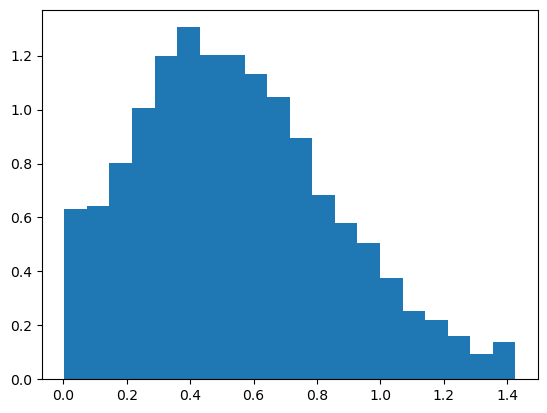

In [98]:
plt.hist(delay(1) / 3600, density = True, bins = 20)

In [121]:
chargers = list(range(1, 21))

bins = np.linspace(0, 3600 + 400, 11)

exp_delay = np.zeros((len(chargers), len(bins) - 1))

for idx, c in enumerate(chargers):

    exp_delay[idx] = np.histogram(delay(c), bins = bins, density = True)[0]

In [122]:
bins

array([   0.,  400.,  800., 1200., 1600., 2000., 2400., 2800., 3200.,
       3600., 4000.])

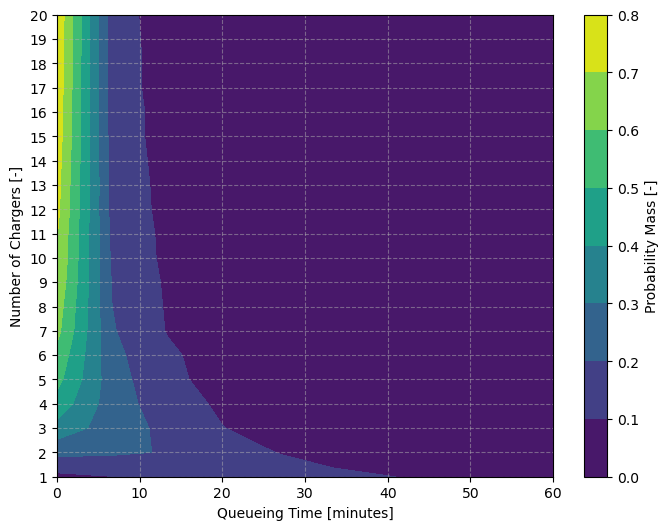

In [136]:
fig, ax  = plt.subplots(1, 1, figsize = (8, 6))

sm = ax.contourf(bins[:-1] / 60, chargers, exp_delay * (bins[1] - bins[0]))
plt.colorbar(sm, ax = ax, label = 'Probability Mass [-]')

kw = {
    'xlabel': 'Queueing Time [minutes]',
    'ylabel': 'Number of Chargers [-]',
    'yticks': range(1, 21),
}

ax.set(**kw)
ax.grid(ls = '--', alpha = .5)

In [75]:
exp_delay[0] / 3600

array([6.34459210e-09, 1.58614803e-08, 6.34459210e-09, 1.26891842e-08,
       2.85506645e-08, 6.02736250e-08, 6.34459210e-08, 1.07858066e-07,
       1.11030362e-07, 1.64959395e-07, 1.93510059e-07, 1.68131691e-07,
       1.64959395e-07, 1.90337763e-07, 3.52124862e-07, 9.83411776e-08,
       1.17374954e-07, 1.01513474e-07, 7.61351052e-08, 1.20547250e-07,
       9.83411776e-08, 1.04685770e-07, 9.83411776e-08, 8.24796973e-08,
       8.56519934e-08, 1.30064138e-07, 1.11030362e-07, 8.24796973e-08,
       1.23719546e-07, 1.01513474e-07, 9.19965855e-08, 1.49097914e-07,
       1.26891842e-07, 1.42753322e-07, 1.17374954e-07, 1.14202658e-07,
       1.30064138e-07, 9.19965855e-08, 1.74476283e-07, 1.68131691e-07,
       1.26891842e-07, 1.77648579e-07, 1.42753322e-07, 9.83411776e-08,
       1.17374954e-07, 1.42753322e-07, 1.07858066e-07, 2.25233020e-07,
       1.64959395e-07, 1.58614803e-07, 1.58614803e-07, 1.58614803e-07,
       1.68131691e-07, 1.71303987e-07, 1.64959395e-07, 1.83993171e-07,
      